# Install dependencies

In [56]:
%pip install scikit-image
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Import main packages

In [2]:
from PIL import Image
import numpy as np 
import skimage
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual

# Load a cube

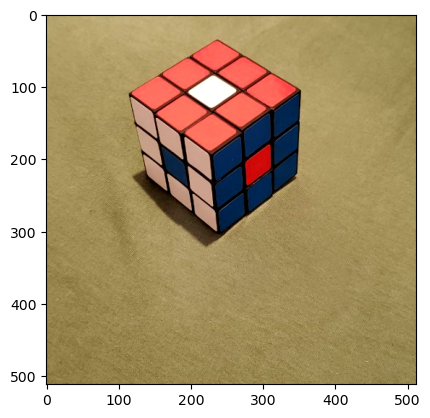

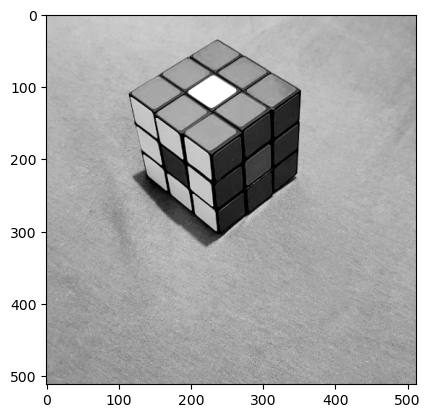

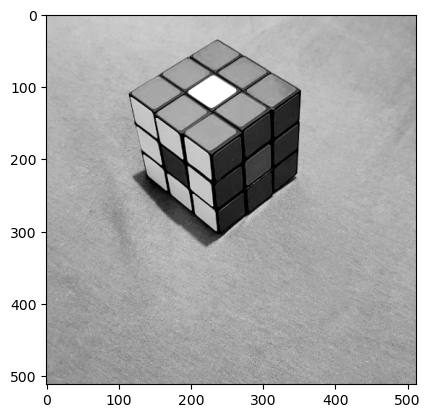

In [29]:

from skimage.color import rgb2gray
from skimage.exposure import adjust_sigmoid
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist, rescale_intensity, adjust_sigmoid, adjust_gamma
from skimage.transform import resize

def crop_at_center(image):
    width, height, _ = image.shape
    size = min([height, width]) * 0.3

    return image[
        round(width/2 - size): round(width/2 + size),
        round(height/2 - size): round(height/2 + size),
    ]

cube = skimage.io.imread("test_images/cube_7.jpg")
cube = crop_at_center(cube)
cube = resize(cube, (512, 512), anti_aliasing=True)

p2, p98 = np.percentile(cube, (2, 98))
cube = rescale_intensity(cube, in_range=(p2, p98))

grey_cube = 1 - rgb2gray(cube)

plt.imshow(cube)
plt.show()

plt.imshow(grey_cube, cmap="Greys")
plt.show()

plt.imshow(adjust_gamma(grey_cube), cmap="Greys")
plt.show()

# Canny border detection

In [30]:
from skimage.feature import canny
from skimage.morphology import binary_dilation, binary_closing, skeletonize, thin
from skimage.morphology import disk, diamond

from skimage.color import rgb2gray, rgb2xyz, rgb2yuv

def extract_borders_canny(image, sigma, closing=1, dilation=1):
    borders = canny(image, sigma)
    closing = binary_closing(borders, disk(closing))
    skeleton = thin(closing)
    dilated = binary_dilation(skeleton, disk(dilation))
    return dilated

def show_borders(sigma=1, closing=1, dilation=3):
    borders = extract_borders_canny(grey_cube, sigma, closing, dilation)
    plt.imshow(cube)
    plt.imshow(borders, cmap="inferno", alpha=(borders == 1) * 0.9)
    plt.show()

interact(show_borders, sigma=(0, 10, 0.1), dilation=(1, 10), closing=(1, 10))

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0), IntSlider(value=1, description='c…

<function __main__.show_borders(sigma=1, closing=1, dilation=3)>

In [31]:
# from skimage.measure import label
from skimage.color import label2rgb
from skimage.segmentation import flood_fill
from skimage import measure
from scipy import ndimage


total_area = grey_cube.shape[0] * grey_cube.shape[1]

def is_quadrilateral(image):
    coords = corner_peaks(corner_harris(image), min_distance=4, threshold_rel=0.05)
    if len(coords) == 3:
        plt.scatter(coords[:, 1], coords[:, 0])
    return True

def extract_regions(sigma=1.6, closing=3, min_area=27, max_area=55):
    borders = 0 == extract_borders_canny(grey_cube, sigma, closing, 1)
    labels, num_labels = ndimage.label(borders)
    props = measure.regionprops(labels)

    for i in range(1, num_labels+1):
        current_label = (labels == i)
        area = props[i - 1].area

        # current_moments = measure.moments(current_label)
        # props = measure.regionprops(current_label)
        # area = current_moments[0, 0]
        # print(len(props))

        if not (min_area**2 < area < max_area**2):
            labels[current_label] = 0

    labels, num_labels = ndimage.label(labels)
    return labels, num_labels

def show_extracted_regions(sigma=1.6, closing=3, min_area=27, max_area=55):
    labels, num_labels = extract_regions(sigma, closing, min_area, max_area)
    print("Regions found:", num_labels)
    print("Expected is 27")
    colored_labels = label2rgb(labels, cube, kind="avg")
    plt.imshow(colored_labels)

interact(
    show_extracted_regions, 
    sigma=(0, 10, 0.1), 
    closing=(1, 10), 
    min_area=(0, np.sqrt(total_area)), 
    max_area=(0, np.sqrt(total_area)),
)


interactive(children=(FloatSlider(value=1.6, description='sigma', max=10.0), IntSlider(value=3, description='c…

<function __main__.show_extracted_regions(sigma=1.6, closing=3, min_area=27, max_area=55)>

In [27]:
from skimage.feature import canny
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage import measure
from collections import defaultdict
from skimage.transform import hough_line, hough_line_peaks


def find_angles(image):
    borders = canny(image)

    hspace, angles, distances = hough_line_peaks(
        *hough_line(borders),
        num_peaks=4,
        min_distance=20,
    )

    # print(len(angles))
    main_angles =  np.unique(np.round(angles)) 
    # print("angles", main_angles)
    # print()

    if len(main_angles) < 2:
        return 0, 1

    # for dist, angle in zip(distances, angles):
    #     angle = round(angle)
    #     slope = np.tan(angle + np.pi/2)
    #     x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
    #     plt.axline((x0, y0), slope=slope)
    # plt.imshow(borders)
    # plt.show()

    return main_angles 

def find_base_changer(i_angle, j_angle):
    i_verser = np.array([np.cos(i_angle), -np.sin(i_angle)])
    i_verser = i_verser / np.linalg.norm(i_verser)

    j_verser = np.array([np.cos(j_angle), -np.sin(j_angle)])
    j_verser = j_verser / np.linalg.norm(j_verser)

    print("angles", i_angle, j_angle)
    print("versers", i_verser, j_verser)
    print()

    canonical_to_current = np.column_stack([i_verser, j_verser])
    current_to_canonical = np.linalg.inv(canonical_to_current)

    # print(current_to_canonical @ i_verser)
    # print(current_to_canonical @ j_verser)
    # print()

    return current_to_canonical

def sort_as_matrix(num_labels, positions):
    label_vals = list(range(1, num_labels + 1))

    min_x = min([x for x, y, z in positions.values()])
    min_y = min([y for x, y, z in positions.values()])
    max_x = max([x for x, y, z in positions.values()])
    max_y = max([y for x, y, z in positions.values()])
    
    def calculate_distance(i):
        x, y, z = positions[i]

        nx = (x - min_x) / (max_x - min_x)
        ny = (y - min_y) / (max_y - min_y)

        distance = (
            nx
            + ny * 5
            + z * 100
        )
        return distance

    labels_sorted = [0] + list(sorted(label_vals, key=calculate_distance))
    label_order = dict()
    for i, val in enumerate(labels_sorted):
        label_order[val] = i

    return label_order


def identify_orientations(sigma=1.6, closing=3, min_area=27, max_area=55):
    labels, num_labels = extract_regions(sigma, closing, min_area, max_area)
    
    group_by_angles = defaultdict(list)
    for i in range(1, num_labels + 1):
        angles = find_angles(labels == i)
        group_by_angles[tuple(angles)].append(i)

    label_transformed_positions = dict()
    for (angle_i, angle_j), group in group_by_angles.items():
        base_changer = find_base_changer(angle_i, angle_j)
        z = (angle_i + angle_j) % (2 * np.pi)
        for i in group:
            current_label = (labels == i)
            centroid = measure.centroid(current_label)
            y, x = base_changer @ centroid
            label_transformed_positions[i] = (x, y, z)
            plt.text(x, y, "@", color="green", fontweight="bold")


    label_order = sort_as_matrix(num_labels, label_transformed_positions)
    for i in range(1, num_labels + 1):
        current_label = (labels == i)
        centroid = measure.centroid(current_label)
        y, x = centroid
        order = label_order[i]
        plt.text(x, y, order, color="orange", fontweight="bold")


    # plt.scatter(list_x, list_y)


    colored_labels = label2rgb(labels, cube, kind="avg")
    plt.imshow(colored_labels)
    


interact(
    identify_orientations, 
    sigma=(0, 10, 0.1), 
    closing=(1, 10), 
    min_area=(0, total_area * 0.015), 
    max_area=(0, total_area * 0.015),
)


interactive(children=(FloatSlider(value=1.6, description='sigma', max=10.0), IntSlider(value=3, description='c…

<function __main__.identify_orientations(sigma=1.6, closing=3, min_area=27, max_area=55)>

In [62]:
a = np.array(
    [
        [0, 0],
        [-1, 1]
    ]
)

c = np.column_stack([[2, 1], [0, 1]])
print(c)

b = np.array([1, 0])

# print(a @ b)

[[2 0]
 [1 1]]


# Sobel border detection

In [65]:
from skimage.feature import canny
from skimage.morphology import binary_dilation, binary_closing, skeletonize, thin
from skimage.morphology import disk, diamond
from skimage.filters import sobel


def extract_borders_sobel(image, sigma, closing=1, dilation=1):
    borders = sobel(image)


    # borders = canny(image, sigma)

    # kernel_closing = np.ones(shape=(closing, closing))
    # closing = binary_closing(borders, disk(closing))

    # skeleton = thin(closing)
    
    # kernel_dilation = np.ones(shape=(dilation, dilation))
    # dilated = binary_dilation(skeleton, disk(dilation))

    return borders

def show_borders(sigma, closing=1, dilation=1):
    borders = extract_borders_sobel(grey_cube, sigma, closing, dilation)
    plt.imshow(cube)
    plt.imshow(borders, cmap="inferno", alpha=1)
    plt.show()

interact(show_borders, sigma=(0, 10, 0.1), dilation=(1, 10), closing=(1, 10))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0), IntSlider(value=1, description='c…

<function __main__.show_borders(sigma, closing=1, dilation=1)>

# Watershed segmentation

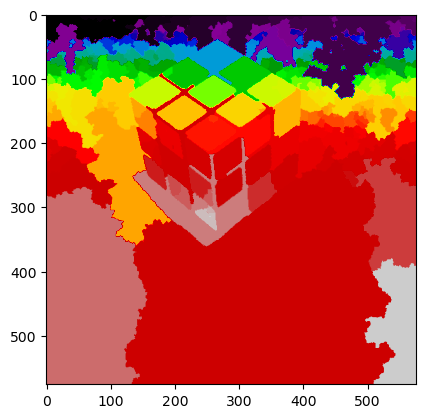

In [66]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = img_as_ubyte(grey_cube)
markers = rank.gradient(image, disk(5)) < 10
markers = ndi.label(markers)[0]
gradient = rank.gradient(image, disk(2))

labels = watershed(gradient, markers)

plt.imshow(labels, cmap=plt.cm.nipy_spectral)
plt.show()

In [67]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.segmentation import slic, mark_boundaries, watershed, felzenszwalb
from skimage.filters import sobel

def segment_by_color(n_segments, compactness, sigma):
    segments = slic(cube, n_segments=n_segments, compactness=compactness, sigma=sigma)
    plt.imshow(segments, interpolation="nearest")
    plt.show()

interact(segment_by_color, n_segments=(0, 100), compactness=(0.1, 1), sigma=(0, 3, 0.1))

# def segment_by_color(scale, sigma, min_size):
#     segments = felzenszwalb(cube, scale=scale, sigma=sigma, min_size=min_size)
#     plt.imshow(segments, interpolation="nearest")
#     plt.show()

# interact_manual(segment_by_color, scale=(0, 100), sigma=(0.1, 1), min_size=50)

interactive(children=(IntSlider(value=50, description='n_segments'), FloatSlider(value=0.55, description='comp…

<function __main__.segment_by_color(n_segments, compactness, sigma)>

In [68]:
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

def extract_lines(sigma, line_length, line_width, line_gap):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    h_angles = np.arange(0, np.pi, 0.01)

    lines = probabilistic_hough_line(dilated, theta=h_angles, threshold=300, line_length=line_length, line_gap=line_gap)

    plt.imshow(cube, alpha=0.4)
    for p0, p1 in lines:
        x = [p0[0], p1[0]]
        y = [p0[1], p1[1]]
        plt.plot(x, y, linewidth=line_width)
    plt.show()

interact(extract_lines, sigma=(0, 5, 0.1), line_length=(0, 500), line_width=(0, 10), line_gap=(0, 1000))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=250, description='…

<function __main__.extract_lines(sigma, line_length, line_width, line_gap)>

In [70]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from scipy.cluster.vq import kmeans
from skimage.segmentation import slic

def extract_lines(sigma, min_distance, min_angle, line_width):
    # borders = canny(grey_cube, sigma)
    # kernel = np.ones(shape=(line_width, line_width))
    # dilated = binary_dilation(borders, kernel)

    borders = extract_borders_canny(grey_cube, sigma, closing=10, dilation=line_width)
    bla = hough_line_peaks(*hough_line(borders), num_peaks=50, min_distance=min_distance, min_angle=min_angle)

    plt.imshow(borders, cmap="Greys")
    for _, angle, dist in zip(*bla):
        slope = np.tan(angle + np.pi/2)
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        plt.axline((x0, y0), slope=slope, color="darkred")

    # print(np.degrees(bla[1]))
    # print(kmeans(np.degrees(bla[1]), k_or_guess=3))

    # mean_angles, _ = kmeans(bla[1], k_or_guess=3)
    # for angle in mean_angles:
    #     slope = np.tan(angle + np.pi/2)
    #     plt.axline((400, 400), slope=slope, color="darkblue")


    # print(borders.shape)
    # print(hough_space.shape)
    # print(angles.shape)
    # print(distances.shape)



    # plt.imshow(np.log(1 + hough_space), aspect='auto', cmap="inferno")
    plt.show()

    # plt.imshow(lines)
    # plt.show()
    # for p0, p1 in lines:
    #     x = [p0[0], p1[0]]
    #     y = [p0[1], p1[1]]
    #     plt.plot(x, y, linewidth=line_width)
    # plt.show()

interact(extract_lines, sigma=(0, 5, 0.1), min_distance=(0, 200), min_angle=(0,200), line_width=(1, 10))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=100, description='…

<function __main__.extract_lines(sigma, min_distance, min_angle, line_width)>

# extract cube mask

In [71]:
from skimage.feature import canny
from skimage.morphology import binary_dilation
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_opening, convex_hull_image, binary_dilation

def extract_cube(sigma, dilation):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(dilation, dilation))

    filled_cube = convex_hull_image(borders)
    filled_cube = binary_opening(filled_cube, kernel)

    plt.imshow(filled_cube, cmap="Greys")
    plt.imshow(borders, cmap="inferno", alpha=0.5)
    plt.show()

interact(extract_cube, sigma=(0, 10, 0.1), dilation=(1, 10))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0), IntSlider(value=5, description='d…

<function __main__.extract_cube(sigma, dilation)>

# Extract squares

In [72]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from scipy.cluster.vq import kmeans
from skimage.segmentation import slic
from itertools import pairwise, chain, combinations


def line_intersection(dist0, angle0, dist1, angle1):
    slope0 = np.tan(angle0 + np.pi/2)
    x0, y0 = dist0 * np.array([np.cos(angle0), np.sin(angle0)])
    bias0 = y0 - slope0 * x0

    slope1 = np.tan(angle1 + np.pi/2)
    x1, y1 = dist1 * np.array([np.cos(angle1), np.sin(angle1)])
    bias1 = y1 - slope1 * x1

    x = (bias1 - bias0) / (slope0 - slope1)
    y = x * slope0 + bias0
    return x, y

def extract_square(da0, da1, da2, da3):
    p0 = line_intersection(*da0, *da2)
    p1 = line_intersection(*da1, *da2)
    p2 = line_intersection(*da1, *da3)
    p3 = line_intersection(*da0, *da3)
    return [p0, p1, p2, p3]

def estract_squares(sigma, min_distance, min_angle, line_width):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    hspace, angles, distances = hough_line_peaks(*hough_line(dilated), num_peaks=50, min_distance=min_distance, min_angle=min_angle)
    means, _ = kmeans(angles, k_or_guess=2)
    
    directions = [
        [],
        [],
        [],
    ]

    print(len(angles))

    for angle, dist in zip(angles, distances):
        diff = np.abs(means - angle)
        index = np.argmin(diff)
        directions[index].append((dist, angle))
    
    for direction in directions:
        direction.sort()

    plt.imshow(dilated, cmap="Greys")
    for dist, angle in chain(*directions):
        slope = np.tan(angle + np.pi/2)
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        plt.axline((x0, y0), slope=slope)

    for v0, v1 in pairwise(directions[0]):
        for h0, h1 in pairwise(directions[1]):
            points = extract_square(v0, v1, h0, h1)
            x_list = [p[0] for p in points]
            y_list = [p[1] for p in points]
            plt.fill(x_list, y_list, alpha=0.5)

    plt.show()

interact(estract_squares, sigma=(0, 5, 0.1), min_distance=(0, 200), min_angle=(0,200), line_width=(1, 10))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=100, description='…

<function __main__.estract_squares(sigma, min_distance, min_angle, line_width)>

# Transformada Hough Paralelograms

In [73]:
from collections import defaultdict


def divide_in_chunks(chunk_size):
    chunks = dict()
    for i in range(0, cube.shape[0], chunk_size):
        for j in range(0, cube.shape[1], chunk_size):
            chunk = cube[i:i+chunk_size, j:j+chunk_size]

            if chunk.shape[0] != chunk_size:
                continue

            if chunk.shape[1] != chunk_size:
                continue

            chunks[i, j] = chunk
    
    w, h, *rest = cube.shape
    combined_shape = (
        w - w % chunk_size,
        h - h % chunk_size,
        *rest
    )
            
    return chunks, combined_shape

def extract_lines(chunk, sigma=2, line_width=1):
    grey_chunk = 1 - rgb2gray(chunk)
    borders = canny(grey_chunk, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)
    hspace, angles, distances = hough_line_peaks(*hough_line(dilated), num_peaks=4)
    return list(zip(distances, angles))

def extract_paralelograms(chunk_size, sigma):
    round_digits = 5
    chunks, combined_shape = divide_in_chunks(chunk_size)
    
    grid_lines = dict()
    for (i, j), chunk in chunks.items():
        lines = extract_lines(chunk, sigma)
        grid_lines[i, j] = lines

    parallel_lines_counter = defaultdict(int)
    for (i, j), lines in grid_lines.items():
        neighbours_lines = []
        neighbours_lines.extend(lines)
        neighbours_lines.extend(grid_lines.get(
            (i+chunk_size, j),
            [],
        ))
        neighbours_lines.extend(grid_lines.get(
            (i, j+chunk_size),
            [],
        ))
        neighbours_lines.extend(grid_lines.get(
            (i+chunk_size, j+chunk_size),
            [],
        ))

        if not neighbours_lines:
            continue

        angle_counter = defaultdict(int)
        for dist, angle in neighbours_lines:
            angle_counter[round(angle, round_digits)] += 1

        for dist, angle in lines:
            if angle_counter[round(angle, round_digits)] > 1:
                parallel_lines_counter[i, j] += 1
                parallel_lines_counter[i+chunk_size, j] += 1
                parallel_lines_counter[i, j+chunk_size] += 1
                parallel_lines_counter[i+chunk_size, j+chunk_size] += 1

    reconstructed = np.zeros(combined_shape, dtype=int)
    for (i, j), chunk in chunks.items():
        reconstructed[i:i+chunk_size, j:j+chunk_size] = chunk
        x = [i, i+chunk_size, i+chunk_size, i]
        y = [j, j, j+chunk_size, j+chunk_size]
        if parallel_lines_counter[i, j] > 1:
            plt.fill(x, y, color="black", alpha=0.7)
        plt.plot(x, y, color="black")


    for (i, j), lines in grid_lines.items():
        for dist, angle in lines:
            slope = np.tan(angle + np.pi/2)
            x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])

            x = [x0+j, x0 + j + 0.3 * chunk_size]
            y = [y0+i, y0 + i + 0.3 * chunk_size * slope]
            plt.plot(x, y)
            # plt.axline((x0+j, y0+i), slope=slope)

    plt.imshow(cube)
    plt.show()

def bla(sigma, chunk_size):
    extract_paralelograms(chunk_size, sigma)    

interact(bla, chunk_size=(0, 200), sigma=(0, 5, 0.1))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=100, description='…

<function __main__.bla(sigma, chunk_size)>

# Detect corners

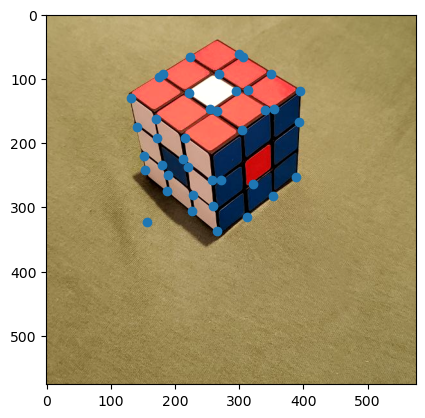

In [74]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

coords = corner_peaks(corner_harris(grey_cube), min_distance=5, threshold_rel=0.02)

plt.imshow(cube)
plt.scatter(coords[:, 1], coords[:, 0])
plt.show()
